## Setup

In [2]:
GLOBAL_SEED = 42

import os
os.environ['PYTHONHASHSEED'] = str(GLOBAL_SEED)
import sys

import gc
from tqdm import tqdm
import datetime
import pickle
import random as rnd
from glob import glob
import pandas as pd
import numpy as np
from numpy import random as np_rnd
import warnings
from math import ceil

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams

from scipy.stats import f_oneway
from scipy.stats import pearsonr

# display setting
warnings.filterwarnings(action='ignore')
rcParams['axes.unicode_minus'] = False

In [3]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    except:
        pass

def create_get_ts(ts):
    return int((ts.replace(tzinfo=CFG.tz) - CFG.ts_zero).total_seconds())

def pickleIO(obj, src, op="w"):
    if op=="w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op=="r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj

def week_of_month(dt):
    """ 
        Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + (1 + first_day.weekday()) % 7
    return int(ceil(adjusted_dom/7.0))

In [4]:
class CFG:
    debug = False
    line_dic = {
        "A": ["T010305", "T010306", "T050304", "T050307"],
        "O": ["T100304", "T100306"],
        "T": ["T100304", "T100306"],
    }

## Loading Data

In [5]:
# information Provided by Dacon

# PRODUCT_ID : 제품의 고유 ID
# Y_Class : 제품 품질 상태(Target) 
# 0 : 적정 기준 미달 (부적합)
# 1 : 적합
# 2 : 적정 기준 초과 (부적합)
# Y_Quality : 제품 품질 관련 정량적 수치
# TIMESTAMP : 제품이 공정에 들어간 시각
# LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
# PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
# X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [6]:
df_full = pd.read_csv("C:/Users/flash/PycharmProjects/pythonProject/projects/dacon_lgaimers2/datasets/train.csv")

In [7]:
df_full.columns = df_full.columns.str.lower()
df_full["timestamp"] = pd.to_datetime(df_full["timestamp"])

In [8]:
# time feature engineernig
df_full["month"] = df_full["timestamp"].dt.month
df_full["day"] = df_full["timestamp"].dt.day
df_full["weekday"] = df_full["timestamp"].dt.weekday
df_full["week_of_month"] = df_full["timestamp"].apply(week_of_month)
df_full["hour"] = df_full["timestamp"].dt.hour
df_full["office_hour"] = df_full["hour"].apply(lambda x: 1 if ((x >= 9) & (x < 18)) else 0)
df_full["sec_in_day"] = (df_full["timestamp"] - df_full["timestamp"].dt.normalize()).dt.total_seconds() / 3600
df_full["sin_in_day"] = np.sin(2 * np.pi * df_full["sec_in_day"].values)
df_full["cos_in_day"] = np.cos(2 * np.pi * df_full["sec_in_day"].values)

## EDA

### Target Distribution (Y_Class)

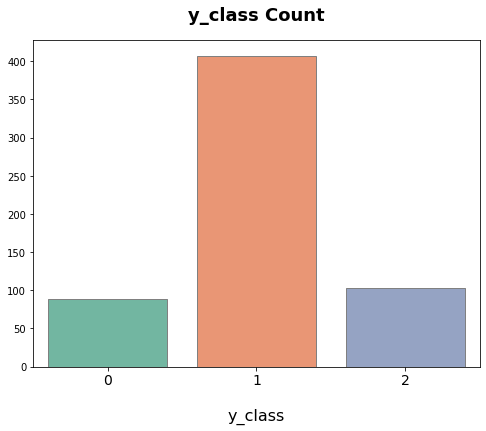

In [8]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=df_full["y_class"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("y_class Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

In [9]:
df_full["y_class"].value_counts(normalize=True).to_frame()

,y_class
1,0.680602
2,0.172241
0,0.147157


### Target Distribution (Y_Quality)

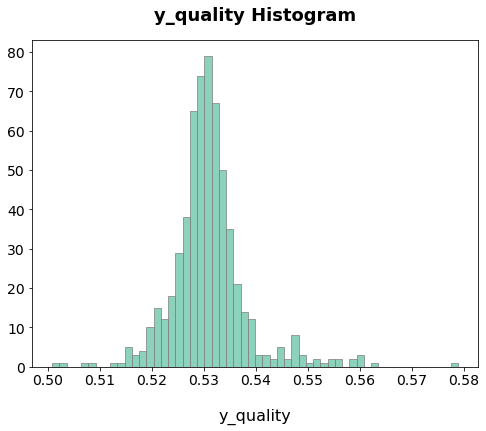

In [10]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.histplot(x=df_full["y_quality"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("y_quality Histogram", fontsize=18, fontweight="bold", pad=20)

plt.show()

In [11]:
df_full["y_quality"].describe().to_frame()

,y_quality
count,598.000000
mean,0.530896
std,0.007401
min,0.500856
25%,0.527535
50%,0.530436
75%,0.533433
max,0.578841


### Line & Product

In [12]:
df_full.groupby(["line", "product_code"]).size()

line     product_code
T010305  A_31             59
T010306  A_31             70
T050304  A_31             78
T050307  A_31             42
T100304  O_31              3
         T_31            172
T100306  O_31              3
         T_31            171
dtype: int64

**All Lines**

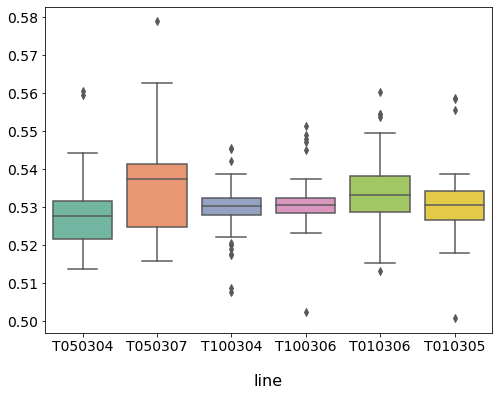

In [13]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=df_full["line"], y=df_full["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [14]:
_, pvalue = f_oneway(*[df_full.loc[df_full["line"] == i, "y_quality"].values for i in df_full["line"].unique()])
print(pvalue)
if pvalue < 0.05:
    print("Lines which produce A product has difference mean")
else:
    print("Lines which produce A product has same mean")

1.2794524144159003e-09
Lines which produce A product has difference mean


**All products**

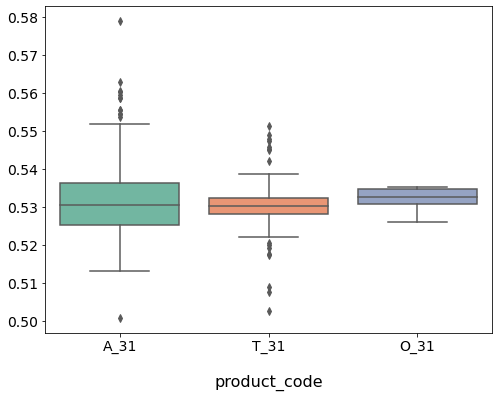

In [15]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=df_full["product_code"], y=df_full["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [16]:
_, pvalue = f_oneway(*[df_full.loc[df_full["product_code"] == i, "y_quality"].values for i in df_full["product_code"].unique()])
print(pvalue)
if pvalue < 0.05:
    print("Lines which produce A product has difference mean")
else:
    print("Lines which produce A product has same mean")

0.07104202816292036
Lines which produce A product has same mean


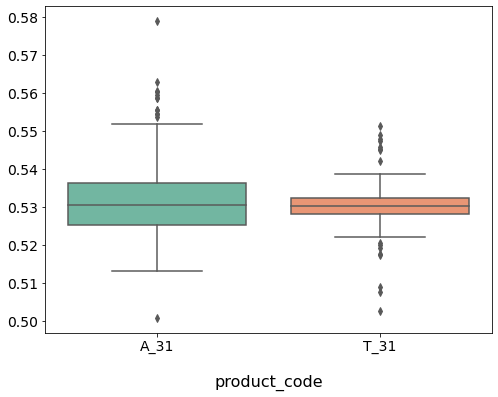

In [17]:
# Except O_31

sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=df_full.loc[df_full["product_code"].isin(["A_31", "T_31"]), "product_code"], y=df_full.loc[df_full["product_code"].isin(["A_31", "T_31"]), "y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [18]:
_, pvalue = f_oneway(*[df_full.loc[df_full["product_code"] == i, "y_quality"].values for i in ["A_31", "T_31"]])
print(pvalue)
if pvalue < 0.05:
    print("Lines which produce A product has difference mean")
else:
    print("Lines which produce A product has same mean")

0.023527004933906446
Lines which produce A product has difference mean


In [19]:
df_a = df_full[df_full["product_code"] == "A_31"]
df_o = df_full[df_full["product_code"] == "O_31"]
df_t = df_full[df_full["product_code"] == "T_31"]

**Product A**

In [20]:
df_a.groupby("line")["y_quality"].describe()

,count,mean,std,min,25%,50%,75%,max
line,,,,,,,,
T010305,59.0,0.530675,0.008780,0.500856,0.526698,0.530497,0.534221,0.558770
T010306,70.0,0.534307,0.009074,0.513135,0.528813,0.533176,0.538079,0.560317
T050304,78.0,0.527951,0.008371,0.513751,0.521655,0.527643,0.531569,0.560568
T050307,42.0,0.535738,0.012841,0.515884,0.524857,0.537443,0.541365,0.578841


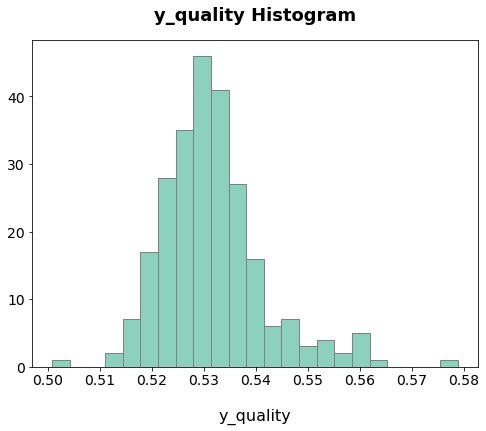

In [21]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.histplot(x=df_a["y_quality"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("y_quality Histogram", fontsize=18, fontweight="bold", pad=20)

plt.show()

In [22]:
df_a.sort_values("timestamp")["line"].to_list()[-20:]

['T050307',
 'T050307',
 'T050304',
 'T050304',
 'T050304',
 'T050304',
 'T050304',
 'T050304',
 'T050304',
 'T050304',
 'T050304',
 'T050304',
 'T050304',
 'T050304',
 'T050304',
 'T050304',
 'T010305',
 'T010306',
 'T050304',
 'T050304']

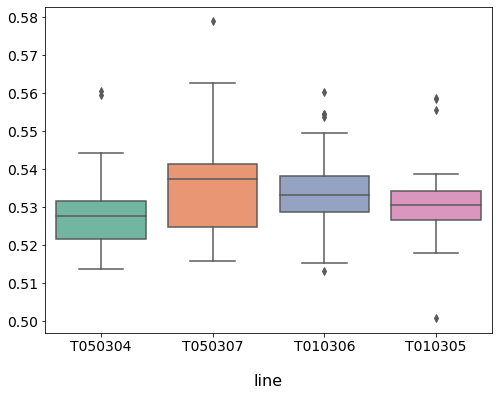

In [23]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=df_a["line"], y=df_a["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [24]:
_, pvalue = f_oneway(*[df_a.loc[df_a["line"] == i, "y_quality"].values for i in df_a["line"].unique()])
print(pvalue)
if pvalue < 0.05:
    print("Lines which produce A product has difference mean")
else:
    print("Lines which produce A product has same mean")

2.181112188029448e-05
Lines which produce A product has difference mean


**Product A timeseries analysis**

In [25]:
# Hour

df_hour = df_a.groupby("hour")["y_quality"].mean().to_frame()
pearsonr(np.array(df_hour.index), np.array(df_hour).flatten())

(-0.26067745947479365, 0.2185894415076187)

In [26]:
_, pvalue = f_oneway(*[df_a.loc[df_a["hour"] == i, "y_quality"].values for i in df_a["hour"].unique()])
print(pvalue)
if pvalue < 0.05:
    print("Lines which produce A product has difference mean")
else:
    print("Lines which produce A product has same mean")

0.005654710374383
Lines which produce A product has difference mean


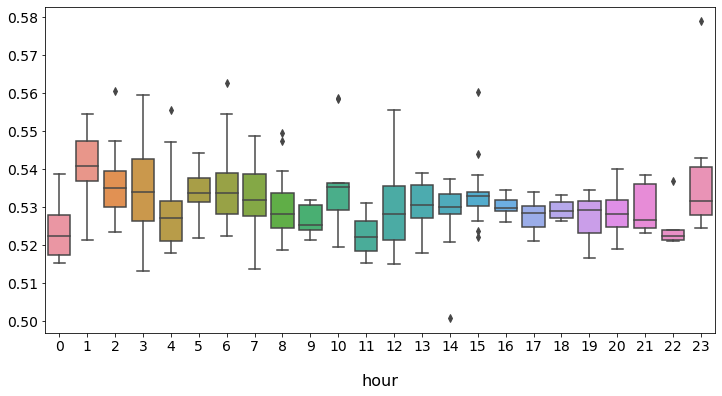

In [27]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x=df_a["hour"], y=df_a["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [28]:
# Sin 

df_hour = df_a["sin_in_day"]
pearsonr(np.array(df_hour.index), np.array(df_hour).flatten())

(0.021032088950458383, 0.741213054819677)

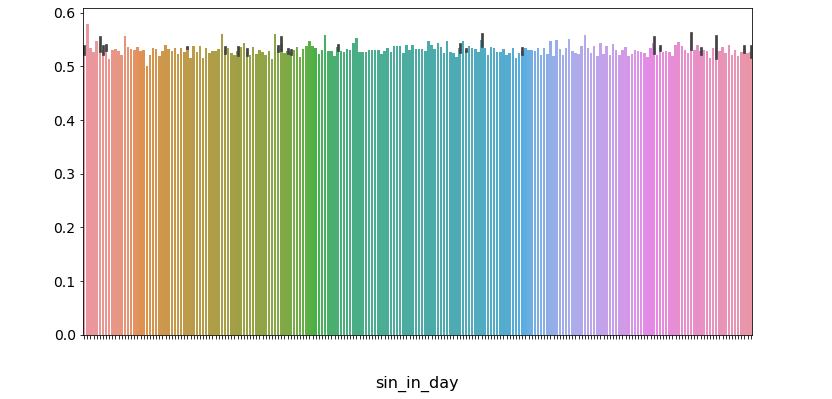

In [29]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=df_a["sin_in_day"], y=df_a["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.xticks(color='white')
plt.yticks(fontsize=14)

plt.show()

In [30]:
# Cos

df_hour = df_a["cos_in_day"]
pearsonr(np.array(df_hour.index), np.array(df_hour).flatten())

(-0.027320261148861477, 0.6679106052568783)

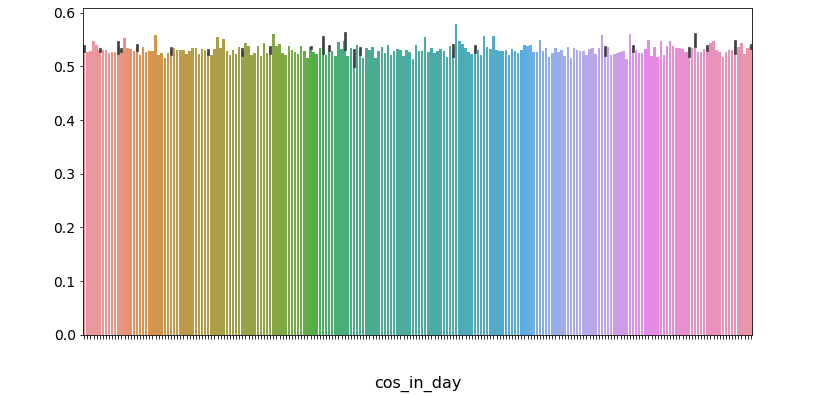

In [31]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=df_a["cos_in_day"], y=df_a["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.xticks(color='white')
plt.yticks(fontsize=14)

plt.show()

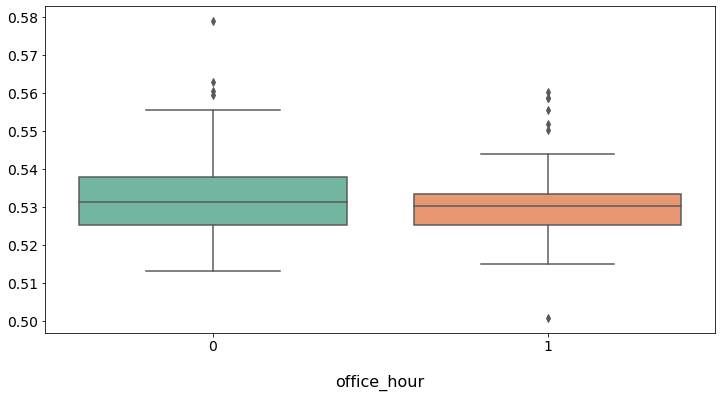

In [32]:
# office hour

sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x=df_a["office_hour"], y=df_a["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [33]:
_, pvalue = f_oneway(df_a.loc[df_a["office_hour"] == 0, "y_quality"], df_a.loc[df_a["office_hour"] == 1, "y_quality"])
print(pvalue)
if pvalue < 0.05:
    print("Lines which produce A product has difference mean")
else:
    print("Lines which produce A product has same mean")

0.19191355373486743
Lines which produce A product has same mean


**Product O**

In [34]:
df_o.groupby("line")["y_quality"].describe()

,count,mean,std,min,25%,50%,75%,max
line,,,,,,,,
T100304,3.0,0.529275,0.002939,0.525916,0.528225,0.530533,0.530954,0.531375
T100306,3.0,0.534619,0.000805,0.533702,0.534326,0.534951,0.535078,0.535205


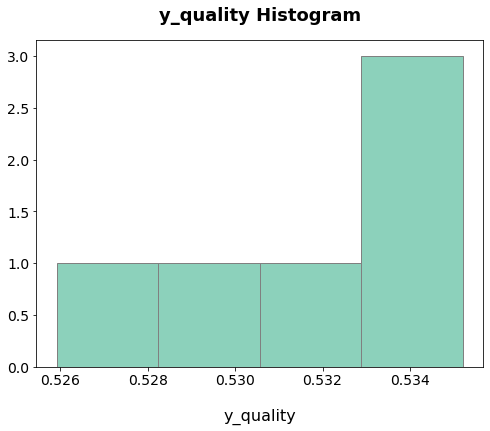

In [35]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.histplot(x=df_o["y_quality"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("y_quality Histogram", fontsize=18, fontweight="bold", pad=20)

plt.show()

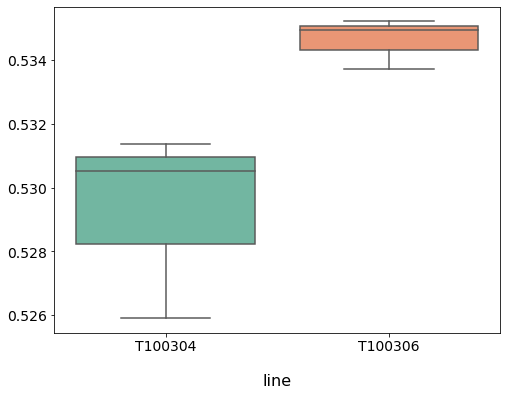

In [36]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=df_o["line"], y=df_o["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [37]:
_, pvalue = f_oneway(*[df_o.loc[df_o["line"] == i, "y_quality"].values for i in df_o["line"].unique()])
print(pvalue)
if pvalue < 0.05:
    print("Lines which produce A product has difference mean")
else:
    print("Lines which produce A product has same mean")

0.038482624653986094
Lines which produce A product has difference mean


**Product O timeseries analysis**

In [38]:
# Hour

df_hour = df_o.groupby("hour")["y_quality"].mean().to_frame()
pearsonr(np.array(df_hour.index), np.array(df_hour).flatten())

(-1.0, 1.0)

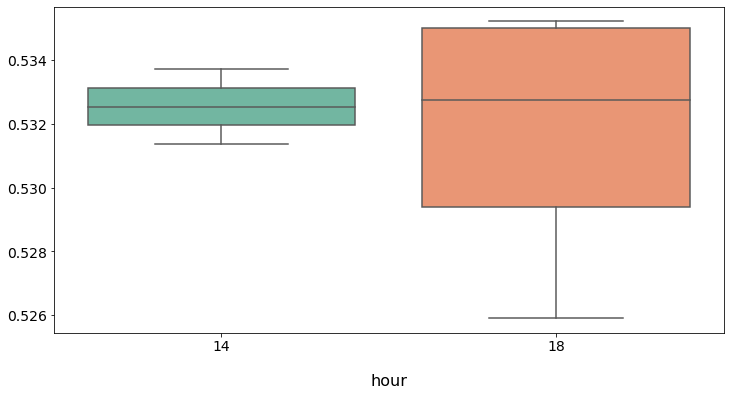

In [39]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x=df_o["hour"], y=df_o["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [40]:
# Sin 

df_hour = df_o["sin_in_day"]
pearsonr(np.array(df_hour.index), np.array(df_hour).flatten())

(-0.44348034075387865, 0.3783901953317586)

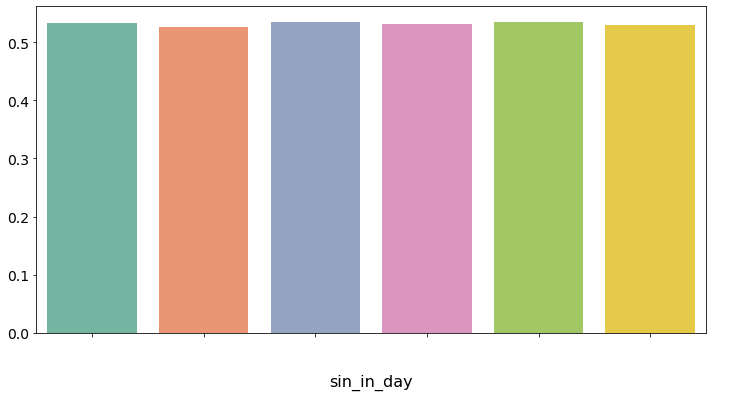

In [41]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=df_o["sin_in_day"], y=df_o["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.xticks(color='white')
plt.yticks(fontsize=14)

plt.show()

In [42]:
# Cos

df_hour = df_o["cos_in_day"]
pearsonr(np.array(df_hour.index), np.array(df_hour).flatten())

(-0.08307792396148254, 0.8756698135412508)

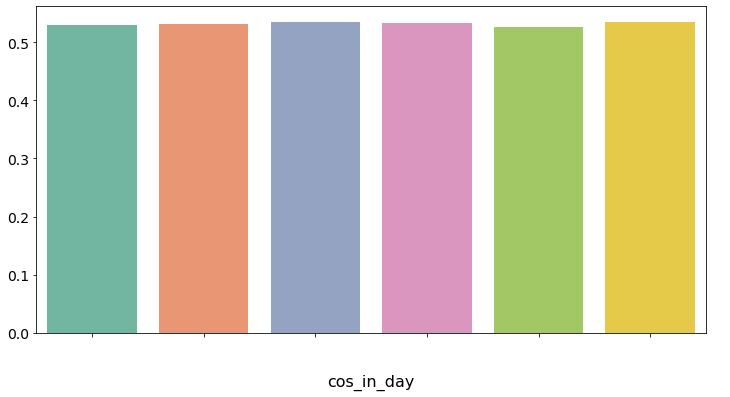

In [43]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=df_o["cos_in_day"], y=df_o["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.xticks(color='white')
plt.yticks(fontsize=14)

plt.show()

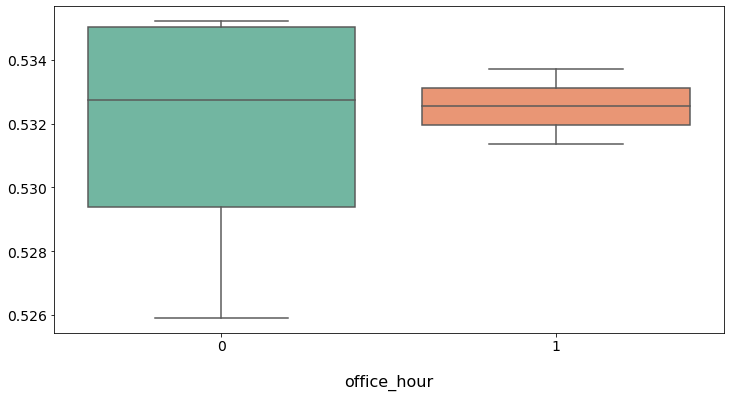

In [44]:
# office hour

sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x=df_o["office_hour"], y=df_o["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [45]:
_, pvalue = f_oneway(df_o.loc[df_o["office_hour"] == 0, "y_quality"], df_o.loc[df_o["office_hour"] == 1, "y_quality"])
print(pvalue)
if pvalue < 0.05:
    print("Lines which produce A product has difference mean")
else:
    print("Lines which produce A product has same mean")

0.8050958103887765
Lines which produce A product has same mean


**Product T**

In [46]:
df_t.groupby("line")["y_quality"].describe()

,count,mean,std,min,25%,50%,75%,max
line,,,,,,,,
T100304,172.0,0.529929,0.00473,0.507571,0.528039,0.530156,0.532405,0.545678
T100306,171.0,0.530667,0.00476,0.502517,0.528387,0.530489,0.532412,0.551279


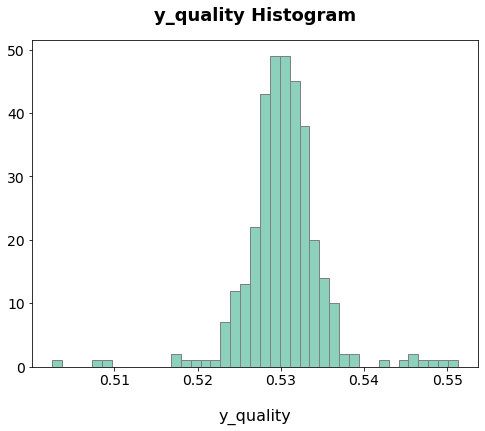

In [47]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.histplot(x=df_t["y_quality"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("y_quality Histogram", fontsize=18, fontweight="bold", pad=20)

plt.show()

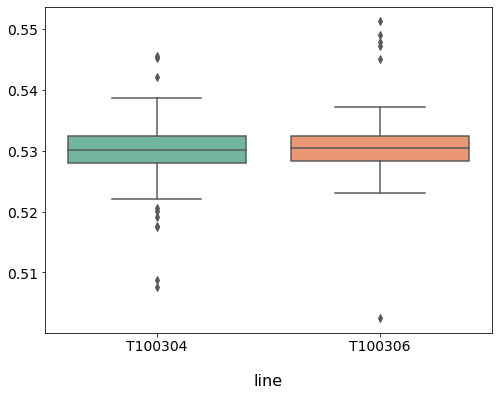

In [48]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=df_t["line"], y=df_t["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [49]:
_, pvalue = f_oneway(*[df_t.loc[df_t["line"] == i, "y_quality"].values for i in df_t["line"].unique()])
print(pvalue)
if pvalue < 0.05:
    print("Lines which produce A product has difference mean")
else:
    print("Lines which produce A product has same mean")

0.151130330256166
Lines which produce A product has same mean


**Product T timeseries analysis**

In [50]:
# Hour

df_hour = df_t.groupby("hour")["y_quality"].mean().to_frame()
pearsonr(np.array(df_hour.index), np.array(df_hour).flatten())

(0.06116435034516679, 0.7764773784117172)

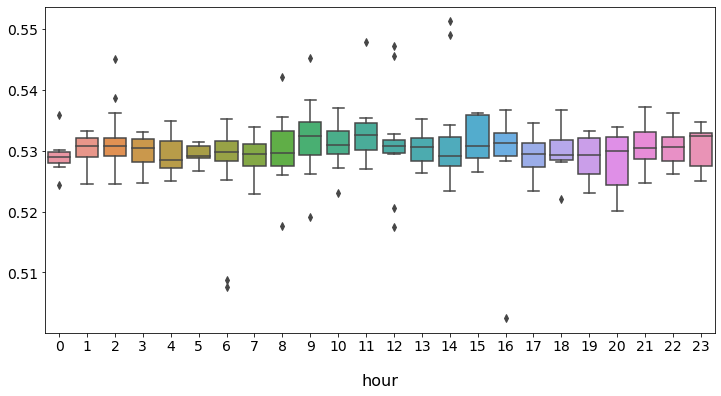

In [51]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x=df_t["hour"], y=df_t["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [52]:
# Sin 

df_hour = df_t["sin_in_day"]
pearsonr(np.array(df_hour.index), np.array(df_hour).flatten())

(-0.06216602003863984, 0.2508699810652044)

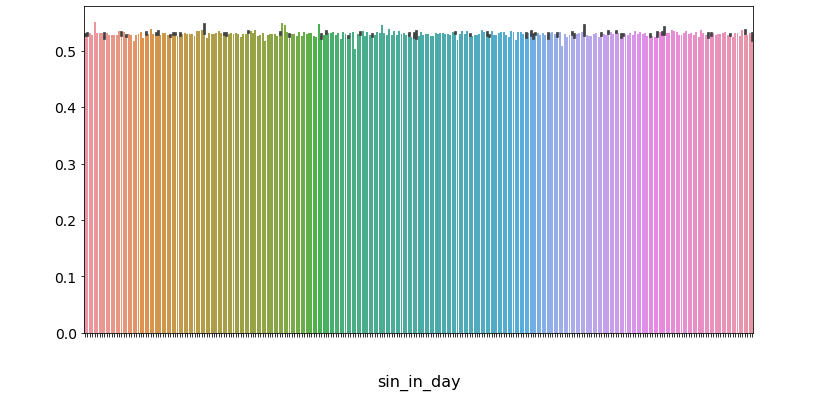

In [53]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=df_t["sin_in_day"], y=df_t["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.xticks(color='white')
plt.yticks(fontsize=14)

plt.show()

In [54]:
# Cos

df_hour = df_t["cos_in_day"]
pearsonr(np.array(df_hour.index), np.array(df_hour).flatten())

(0.061104313736195195, 0.25907019264498066)

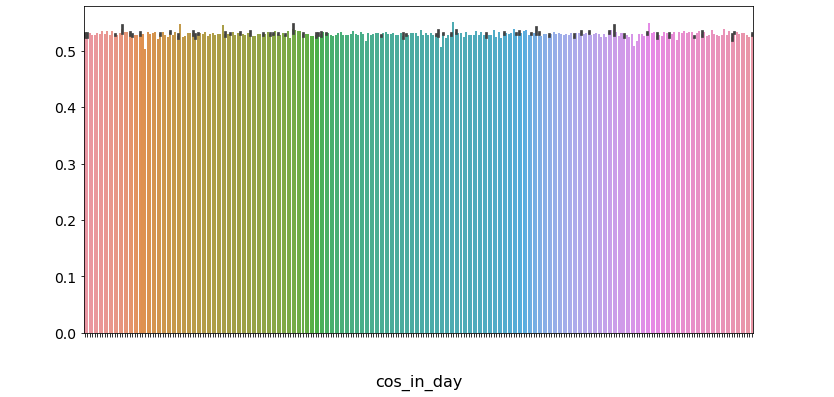

In [55]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=df_t["cos_in_day"], y=df_t["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.xticks(color='white')
plt.yticks(fontsize=14)

plt.show()

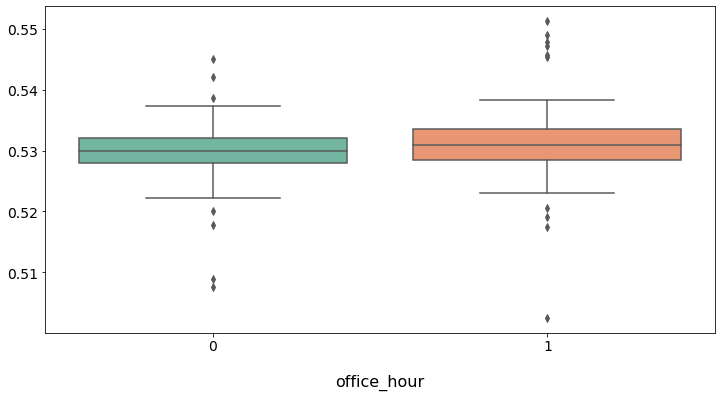

In [56]:
# office hour

sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x=df_t["office_hour"], y=df_t["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [57]:
_, pvalue = f_oneway(df_t.loc[df_t["office_hour"] == 0, "y_quality"], df_t.loc[df_t["office_hour"] == 1, "y_quality"])
print(pvalue)
if pvalue < 0.05:
    print("Lines which produce A product has difference mean")
else:
    print("Lines which produce A product has same mean")

0.008462771714177435
Lines which produce A product has difference mean


**Line - O, T**

In [58]:
df_tmp = df_full[df_full["product_code"].isin(["O_31", "T_31"])]

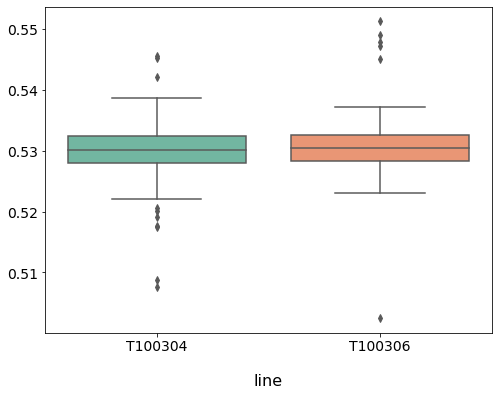

In [59]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=df_tmp["line"], y=df_tmp["y_quality"])

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [60]:
_, pvalue = f_oneway(*[df_tmp.loc[df_tmp["line"] == i, "y_quality"].values for i in df_tmp["line"].unique()])
print(pvalue)
if pvalue < 0.05:
    print("Lines which produce A product has difference mean")
else:
    print("Lines which produce A product has same mean")

0.10728172949703838
Lines which produce A product has same mean


**Lines - timeseries**

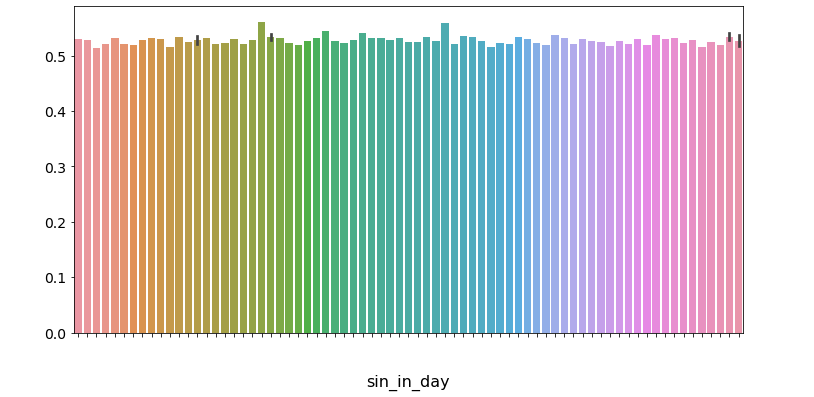

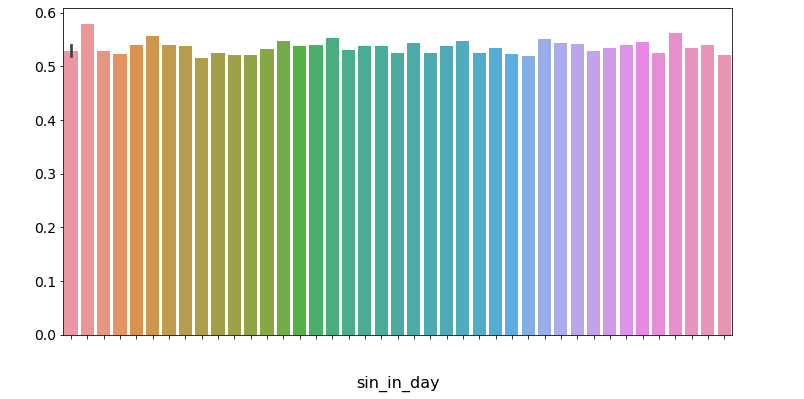

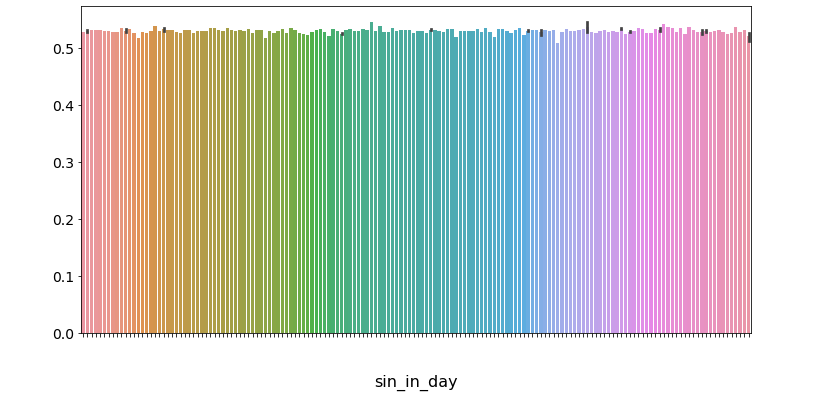

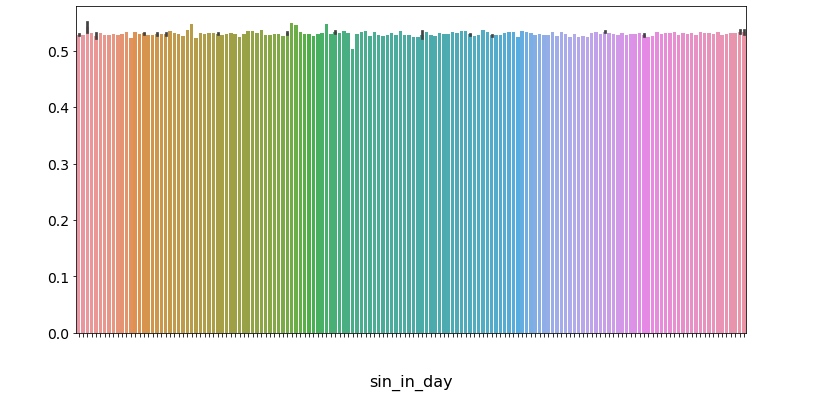

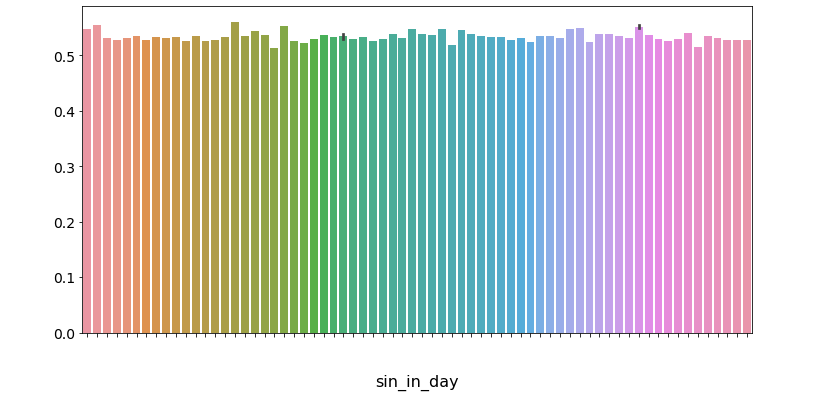

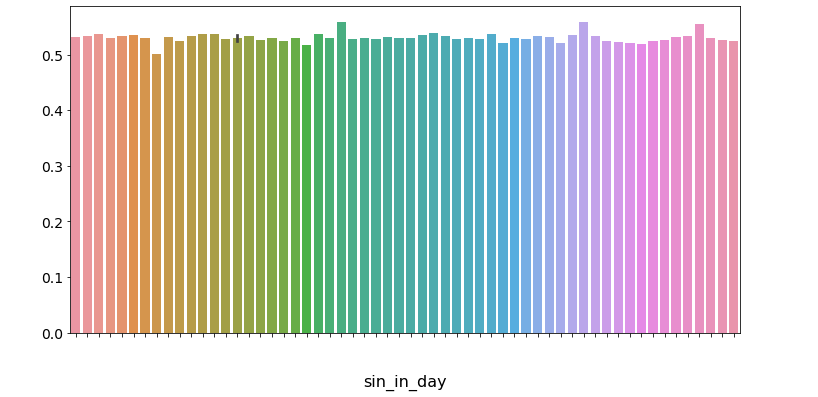

In [61]:
sns.set_palette("Set2")

for i in df_full["line"].unique():
    fig, ax = plt.subplots(figsize=(12, 6))
#     sns.lineplot(x=df_full.loc[df_full["line"] == i, "sin_in_day"], y=df_full.loc[df_full["line"] == i, "y_quality"])
    sns.barplot(x=df_full.loc[df_full["line"] == i, "sin_in_day"], y=df_full.loc[df_full["line"] == i, "y_quality"])

    plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
    plt.ylabel("", fontsize=16, labelpad=20)

    plt.xticks(fontsize=14)
    plt.xticks(color='white')
    plt.yticks(fontsize=14)

    plt.show()

**Test data**

In [9]:
df_test = pd.read_csv("C:/Users/flash/PycharmProjects/pythonProject/projects/dacon_lgaimers2/datasets/test.csv")

In [12]:
df_test.columns = df_test.columns.str.lower()
df_test["timestamp"] = pd.to_datetime(df_test["timestamp"])

In [16]:
df_full.groupby(["line", "product_code"]).size()

line     product_code
T010305  A_31             59
T010306  A_31             70
T050304  A_31             78
T050307  A_31             42
T100304  O_31              3
         T_31            172
T100306  O_31              3
         T_31            171
dtype: int64

In [15]:
df_test.groupby(["line", "product_code"]).size()

line     product_code
T010305  A_31             14
T010306  A_31             14
T050304  A_31             13
T050307  A_31             26
T100304  O_31              3
         T_31            108
T100306  O_31              1
         T_31            131
dtype: int64